<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/Owen_Unit4ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
#print the dataframe wiht the new column
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [ ]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_T_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 30)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 10, nu = 30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 30,
                      dims = "aa")

    ν = pm.HalfStudentT('ν', sigma = 10, nu = 30, dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical, T for StudentT
    idata_cs_h_T = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_N_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical, N for Normal
    idata_cs_h_N = pm.sample()

Output()

Output()

array([<Axes: >], dtype=object)

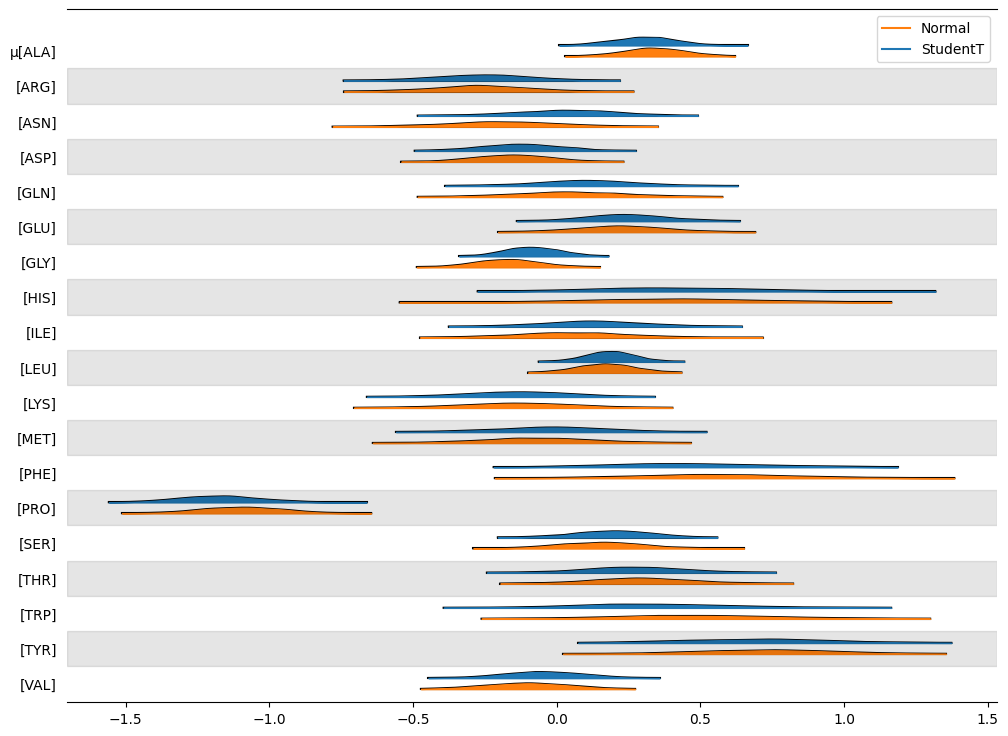

In [ ]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
az.plot_forest([idata_cs_h_T,idata_cs_h_N], kind="ridgeplot",
                      var_names='μ', model_names=['StudentT','Normal'],
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Most of the group posteriors are pretty similar between models. It looks like for the majority of the groups the StudenT model moves the ridge plot closer to the mean of the hyperprior, but it isn't a very significant difference.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-15.0, 15.0)

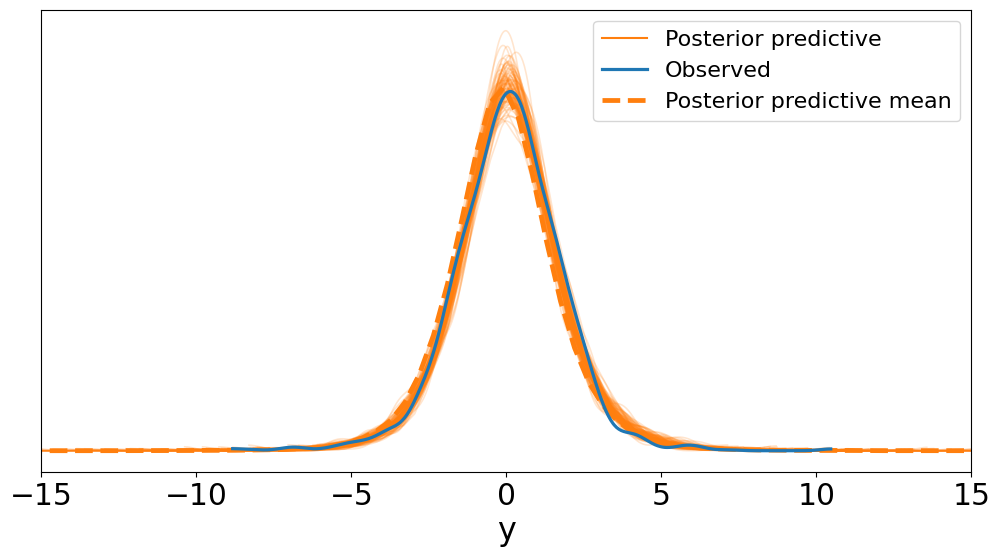

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_T, model=cs_h_T_model, extend_inferencedata=True)
aT=az.plot_ppc(idata_cs_h_T, num_pp_samples=100, figsize=(12,6), colors=["C1", "C0", "C1"])
aT.set_xlim(-15, 15)

Output()

(-15.0, 15.0)

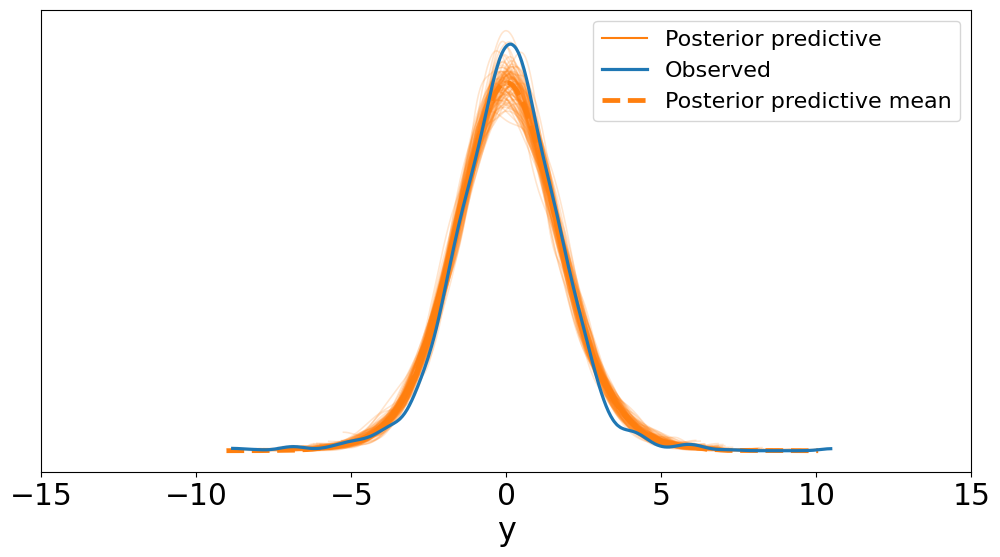

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_N, model=cs_h_N_model, extend_inferencedata=True)
aN=az.plot_ppc(idata_cs_h_N, num_pp_samples=100, figsize=(12,6), colors=["C1", "C0", "C1"])
aN.set_xlim(-15, 15)

The StudentT model definitely appears to fit the observed data better than the Normal model does. The Normal model doesn't peak as high as the data does, whereas the data is almost entirely contained within the posterior predictive check of the StudentT model.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

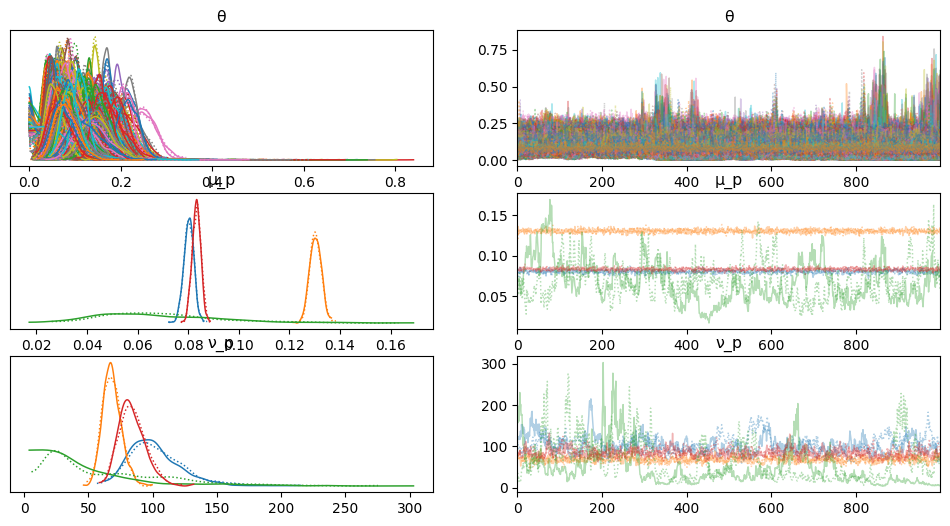

In [ ]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

These distributions appears relatively similar to those from the hierarchical model. The mu_p and nu_p distributions for GKs have a wider range to the right, reaching about 0.17 and 300 respectively versus 0.14 and 200 from the hierarchical model. This suggests that this model is even less sure of what to do with GKs, which makes sense since it can no longer make inferences based on what is happening with other positions. The theta plot is also more spread out than before, although this is probably an artifact of the same behavior with GKs. The red and blue peaks on mu_p are no longer the same height as they were for the hierarchical model, and overall the values on each distribution for non GKs seem more concentrated and bunched together; there is a greater kurtosis value.

In [ ]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.005 0.9996 1.0 1.0 ... 1.001 1.002 1.003
    μ_p      (pos) float64 32B 0.9999 0.9993 1.019 1.0
    ν_p      (pos) float64 32B 1.017 1.0 1.101 1.004

For theta, the rhat values still don't deviative much from 1, which is very similar to the hierarchical model. At most, they're about 0.005 away from 1.

For mu_p, the rhat values are much better than the ones from the hierarchical model. The largest value is 1.019, whereas before we got 1.242, which is an extremely high and concerning value.

For nu_p, the rhat values are slightly, although not super noticeably, worse than the ones from the hierarchical model. The largest value is 1.101, whereas before the greatest value was 1.093, so not a huge difference but slightly worse.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

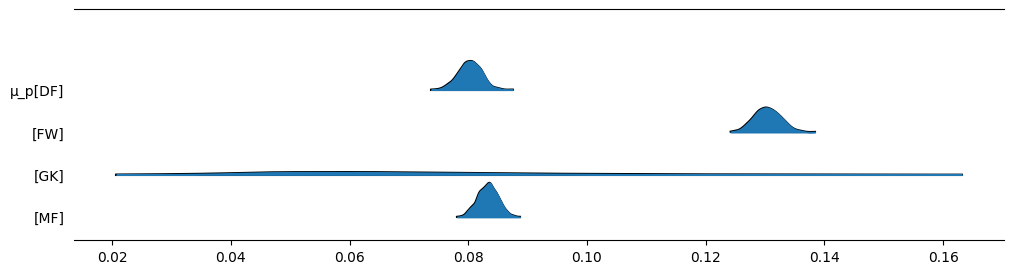

In [ ]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These means are basically identical to the ones from the hierarchical model. The curve appears to be a little more bumpy comapred to the in class model, but that might just be an artificant of sampling variability. The GK plot specifically also appears to have a larger range than before, stretching from 0.0.02 to 0.16 versus 0.02 to 0.12 before. Overall though, the shape and location are basically indistinguishable from before.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data_noGK = pd.read_csv(url_sccr)
sccr_data_noGK = sccr_data_noGK.query('position != "GK"')
sccr_data_noGK.reset_index(drop=True, inplace=True)
sccr_data_noGK['position'] = sccr_data_noGK['position'].astype('category')
sccr_data_noGK

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2512,Óscar Mingueza,DF,2,12
2513,Óscar Plano,MF,12,124
2514,Óscar Rodríguez,MF,13,133
2515,Óscar Trejo,MF,1,20


In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx_noGK = sccr_data_noGK.position.cat.codes.values

#an array of the three strings that represent position
pos_codes_noGK = sccr_data_noGK.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords_noGK = {"pos": pos_codes_noGK}

In [ ]:
with pm.Model(coords = sccr_coords_noGK) as sccr_model_noGK:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGK], nu = ν_p[pos_idx_noGK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

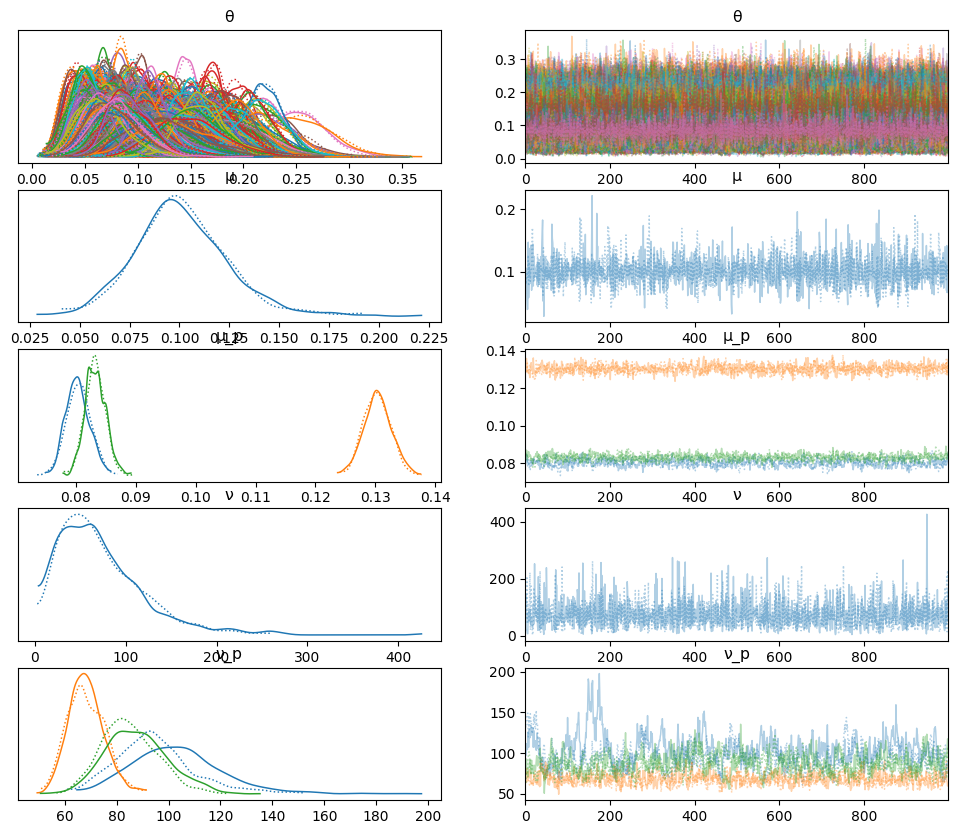

In [ ]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr_noGK)

In [ ]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr_noGK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.005 1.0 0.9995 1.0 ... 0.9998 1.002 1.002
    μ        float64 8B 1.004
    μ_p      (pos) float64 24B 1.001 1.001 1.002
    ν        float64 8B 0.9996
    ν_p      (pos) float64 24B 1.056 1.004 1.011

array([<Axes: >], dtype=object)

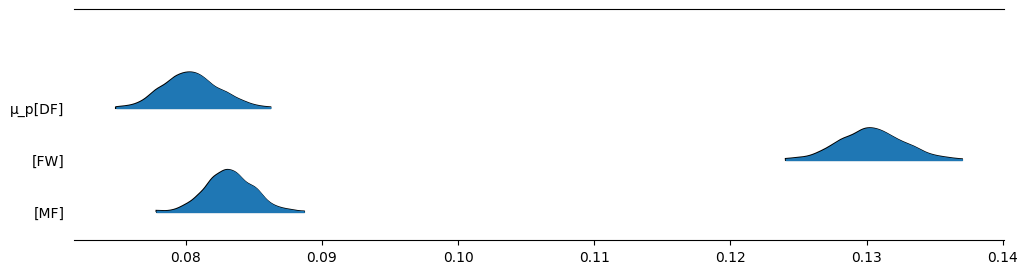

In [ ]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr_noGK, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The model without goalkeepers was a lot easier for pymc to process because there's less overall data to deal with and it doesn't have to deal with weird edge cases where players (goalkeepers) took 0 shots and scored 0 goals, resulting in a percentage of 0/0. It took about half the time to finish running. There's also no more of that weird spiky behavior that was present in some of the markov chains on the plot trace before.

When you drop GKs from the data set, you lose all of the information about goal scoring from that position. Maybe you care about a specific goalkeeper's remarkable scoring ability and you can't analyze them anymore because you dropped all GKs from the data set. What we gain is that the goalkeeper part of the model no longer affect the other parts of the model through the hyperpriors. This is good because knowing information about how often goalkeepers score probably shouldn't tell us anything about how often the other positions score, because playing goalkeeper is extremely different to playing any other position in soccer.